In [356]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import resample
import random
# Import necessary libraries
from keras.datasets import cifar10

In [357]:
import datetime
import os
import json
from datetime import datetime

config = {
    'currentModel' : 'BNN',
    'training' : True,
    'overFit' : False,
    'heldOutClasses' : False,
    'epochs' : 20,
    'patience' : 10,
    'saveModel' : True,
    'seed': 0,
    'batchSize' : 32
}

config['ensembleSize'] = 20 if 'ENSEMBLE' in config['currentModel'] else 1
config['startEpochs'] = 20 if 'overFit' in config['currentModel'] else 1


In [358]:
# Here we want to load every config.json file in the ./models/** folder and create a dataframe with all the results

import glob
import json
import pandas as pd

# Path to search for 'config.json' files
path = './models/**/config.json'

# Find all matching files
files = glob.glob(path, recursive=True)
data = []
for file in files:
    with open(file, 'r') as f:
        content = json.load(f)
        content['path'] = file
        data.append(content)
df = pd.DataFrame(data)


matching_conditions = [
    ('currentModel', 'BNN'),
    ('heldOutClasses', True),
]

for condition in matching_conditions:
    df = df[df[condition[0]] == condition[1]]

# Display the DataFrame
print(df)


  currentModel  training  overFit  heldOutClasses  epochs  patience  \
0          BNN      True    False            True      20        10   

   saveModel  seed  ensembleSize  startEpochs     dateRun  batchSize  \
0       True     0             1            1  2024-04-29          1   

                                path  
0  ./models/2024-04-29/0/config.json  


In [359]:

# LOAD_MODEL_LOCATION = './models/2024-04-25/0/'
LOAD_MODEL_LOCATION = ''


In [360]:

if LOAD_MODEL_LOCATION:
    config = json.load(open(f'{LOAD_MODEL_LOCATION}/config.json'))
    config['training'] = False
    config['saveModel'] = False
    MODEL_FILE = f'{LOAD_MODEL_LOCATION}'
    config_content = json.load(open(f'{MODEL_FILE}/config.json')) 
    print(config_content)
else:
    # Formatted as 'YYYY-MM-DD'
    today = datetime.today().strftime('%Y-%m-%d')
    config['dateRun'] = today
    # Get all the directories in the models folder
    os.makedirs(f'./models/{today}', exist_ok=True)
    dirs = os.listdir(f'./models/{today}')
    dir_name = max([int(d) for d in dirs]) + 1 if dirs else 0

    MODEL_FILE = f'./models/{today}/' + str(dir_name)

    os.makedirs(f'{MODEL_FILE}', exist_ok=True)

    with open(f'{MODEL_FILE}/config.json', 'w+') as f:
        # write json to file as double quoted and formatted
        json.dump(config, f, indent=4)


np.random.seed(config['seed'])
# set random seed for tf
tf.random.set_seed(config['seed'])
# random seed for python built-in random module
random.seed(config['seed'])

In [361]:
from sklearn.model_selection import train_test_split

dataset = cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

if config['heldOutClasses']:
    config['heldOutClasses'] = [0, 1]
else:
    config['heldOutClasses'] = []

held_out_class_indices_train = np.where(np.isin(train_labels, config['heldOutClasses']))[0]    
held_out_class_indices_test = np.where(np.isin(test_labels, config['heldOutClasses']))[0]    

not_frog_indices = np.setdiff1d(not_frog_indices, held_out_class_indices_train)

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

# Downsampled feature and label sets
train_labels = np.where(train_labels == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images[downsampled_indices]
train_labels = train_labels[downsampled_indices]

test_images_held_out = test_images[held_out_class_indices_test]
test_labels_held_out = test_labels[held_out_class_indices_test]

test_images = np.delete(test_images, held_out_class_indices_test, axis=0)
test_labels = np.delete(test_labels, held_out_class_indices_test, axis=0)


# Split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=config['seed'])




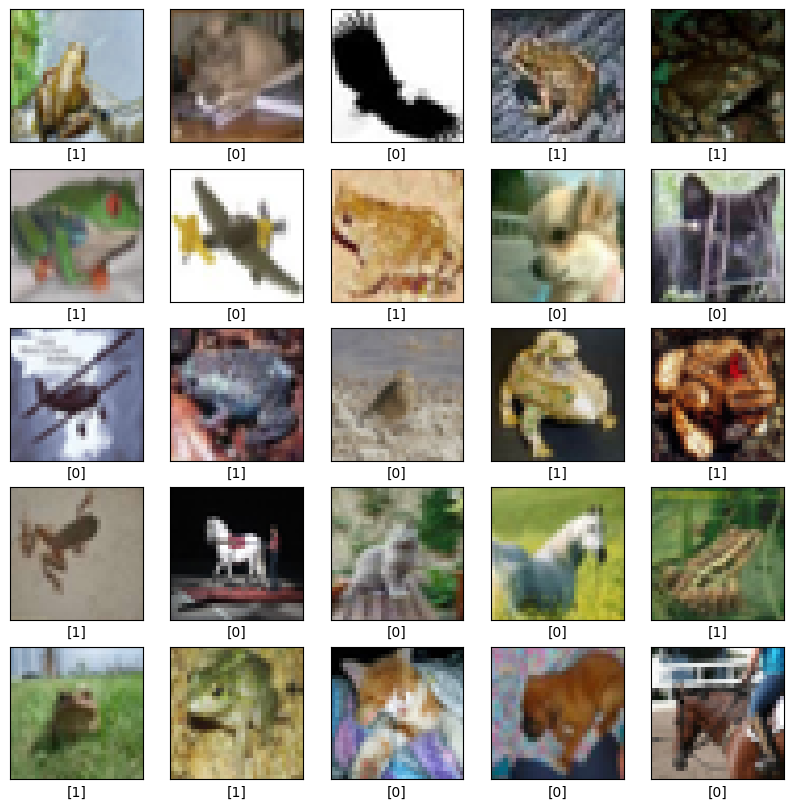

In [362]:
class_names = ['not_frog', 'frog']

randomly_chosen_indexes = np.random.uniform(0, len(train_images), 25).astype(int)
plt.figure(figsize=(10,10))
for i, value in enumerate(randomly_chosen_indexes):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[value])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_labels[value])
plt.show()

### Compile and train the model

In [363]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}


for i in range(config['ensembleSize']): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}}


In [364]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model

# Function to set dropout rate
def set_dropout_rate(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = new_rate


def create_dropout_model(dropout_rate=0.5):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model
  

In [365]:
 
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

def create_model():
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [367]:
from tensorflow.keras.callbacks import TensorBoard

if config['training']:

    for i in range(config['ensembleSize']):

        # Define the early stopping callback
        early_stopping = EarlyStopping(monitor='val_auc', patience=config['patience'], start_from_epoch=config['startEpochs'], restore_best_weights=True, mode='max')

        log_dir = f"{MODEL_FILE}/tenserboard/{i}"
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        # Define the model checkpoint callback
        model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}/{i}.keras', monitor='val_auc', save_best_only=True)

        callbacks = [early_stopping, tensorboard_callback]

        if config['saveModel']:
            callbacks.append(model_checkpoint)


        model = create_dropout_model() if config['currentModel'] == 'BNN' else create_model()
        
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])

        set_dropout_rate(model, np.nextafter(np.float32(0), np.float32(1))) if config['currentModel'] == 'BNN' else ''

        X_train_subset, y_train_subset = resample(train_images, train_labels)

        history = model.fit(X_train_subset, y_train_subset, epochs=config['epochs'],
                            validation_data=(val_images, val_labels),
                            callbacks=[early_stopping, model_checkpoint], batch_size=config['batchSize'])

        set_dropout_rate(model, 0.5) if config['currentModel'] == 'BNN' else ''

        history_list[i].append(history)

        for history in history_list[i]:
            for key in history_dict_base.keys():
                history_dict[i][key].extend(history.history[key])


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6965 - auc: 0.7599 - loss: 0.5659 - val_accuracy: 0.7465 - val_auc: 0.8940 - val_loss: 0.5222
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8174 - auc: 0.8990 - loss: 0.4007 - val_accuracy: 0.8195 - val_auc: 0.9259 - val_loss: 0.3948
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8489 - auc: 0.9282 - loss: 0.3403 - val_accuracy: 0.8590 - val_auc: 0.9402 - val_loss: 0.3358
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8748 - auc: 0.9476 - loss: 0.2925 - val_accuracy: 0.8440 - val_auc: 0.9470 - val_loss: 0.3638
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9020 - auc: 0.9660 - loss: 0.2368 - val_accuracy: 0.8330 - val_auc: 0.9507 - val_loss: 0.4160
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9112 - auc: 0.9731 - loss: 0.2109 - val_accuracy: 0.8655 - val_auc: 0.9511 - val_loss: 0.3670
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 

In [368]:
if config['currentModel'] == 'BNN':
    import numpy as np
    from tensorflow.keras.models import load_model

    class MCDropoutModel:
        def __init__(self, base_model, num_predictions=100, dropout_rate=0.5):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack

    loaded_model = load_model(f'{MODEL_FILE}/0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = MCDropoutModel(loaded_model, num_predictions=20)

In [369]:

# set_dropout_rate(loaded_model, 0.5)
# model_with_two_predictions = MCDropoutModel(loaded_model, num_predictions=2)

# predictions = model_with_two_predictions.verbose_predict(test_images[:4])

In [370]:
if config['currentModel'] == 'ENSEMBLE':
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Average
    from tensorflow.keras.models import load_model


    class EnsembleModel(tf.keras.Model):
        def __init__(self, models, **kwargs):
            super(EnsembleModel, self).__init__(**kwargs)
            self.models = models

        def call(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Average the outputs of each model
            # First, stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            # Then, calculate the mean along the first axis
            outputs_mean = tf.reduce_mean(outputs_stack, axis=0)

            return outputs_mean
        
        def verbose_predict(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack


    model_list = []

    for i in range(config['ensembleSize']): 
        ensemble_member = load_model(f'{MODEL_FILE}/{i}.keras')
        ensemble_member.evaluate(test_images, test_labels)
        model_list.append(ensemble_member)


    # Create the ensemble model
    model_under_test = EnsembleModel(model_list)

    # Compile the ensemble model
    model_under_test.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

    # model_under_test(test_images)

    # Evaluate the ensemble model
    performance = model_under_test.evaluate(test_images, test_labels)
    if config['heldOutClasses']:
        performance = model_under_test.evaluate(test_images_held_out, test_labels_held_out)
    print('Performance:', performance)
    # print('Ensemble accuracy:', accuracy)


313/313 - 2s - 5ms/step - accuracy: 0.6128 - auc: 0.9024 - loss: 0.7702


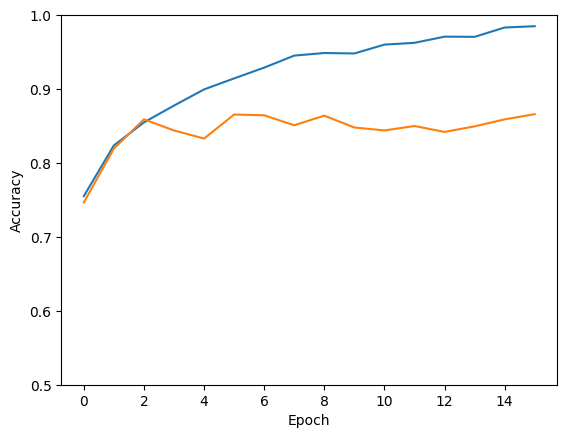

In [371]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(config['ensembleSize']):
    model = load_model(f'{MODEL_FILE}/{i}.keras')
    plt.plot(history_dict[i]['accuracy'], label=f'accuracy {i}')
    plt.plot(history_dict[i]['val_accuracy'], label = f'val_accuracy {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])

    test_loss, test_acc, test_auc = model.evaluate(test_images,  test_labels, verbose=2)

In [372]:
import pandas as pd

def produce_df_from_predictions(model_under_test, test_images, test_labels):
    outputs_stack = model_under_test.verbose_predict(test_images)
    outputs_mean = np.mean(outputs_stack, axis=0)
    outputs_variance = np.var(outputs_stack, axis=0)
    ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
    individual_outputs = np.array(outputs_stack).squeeze().T.tolist()
    output_confidence = np.abs(outputs_mean - 0.5)
    prediction_outcome = np.where(ensemble_predictions != test_labels, 0, 1)
    np_df = np.hstack((output_confidence, outputs_variance, prediction_outcome, outputs_mean, test_labels, ensemble_predictions))
    df = pd.DataFrame(np_df, columns=['confidence', 'variance', 'outcome', 'mean', 'label', 'prediction'])
    df['individual_predictions'] = individual_outputs
    print(df.head())
    df['tp'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 1), axis=1)
    df['fp'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 1), axis=1)
    df['tn'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 0), axis=1)
    df['fn'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 0), axis=1)

    df.head()

    return df

df = produce_df_from_predictions(model_under_test, test_images, test_labels)

df_held_out = produce_df_from_predictions(model_under_test, test_images_held_out, test_labels_held_out)
print(df_held_out.head())


   confidence  variance  outcome      mean  label  prediction  \
0    0.143188  0.080015      0.0  0.643188    0.0         1.0   
1    0.416994  0.014437      1.0  0.083006    0.0         0.0   
2    0.419749  0.012500      1.0  0.080251    0.0         0.0   
3    0.316695  0.068381      1.0  0.183305    0.0         0.0   
4    0.196792  0.083023      1.0  0.696792    1.0         1.0   

                              individual_predictions  
0  [0.6422299146652222, 0.9896552562713623, 0.502...  
1  [0.057218972593545914, 0.0012641382636502385, ...  
2  [0.0018965221242979169, 0.13751530647277832, 0...  
3  [0.233693465590477, 0.0010108337737619877, 0.0...  
4  [0.9019640684127808, 0.06968282908201218, 0.30...  
Empty DataFrame
Columns: [confidence, variance, outcome, mean, label, prediction, individual_predictions]
Index: []
Empty DataFrame
Columns: [confidence, variance, outcome, mean, label, prediction, individual_predictions, tp, fp, tn, fn]
Index: []


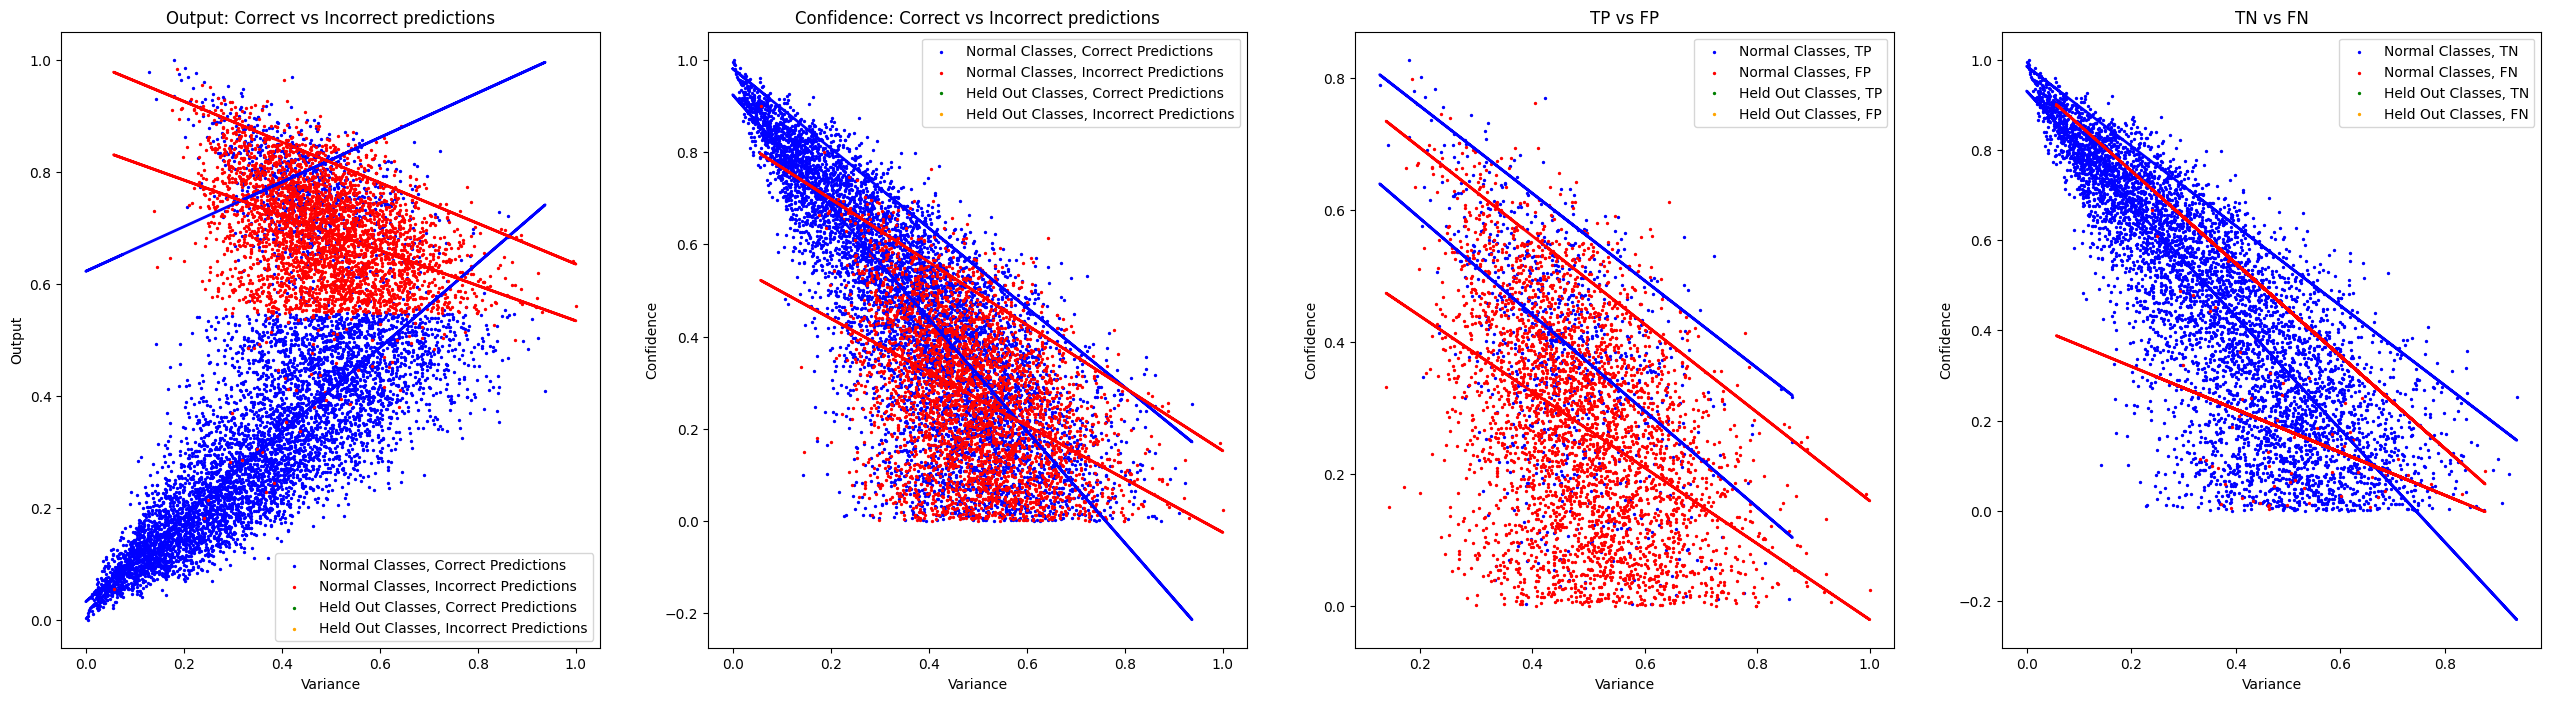

In [373]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

def normalize_and_plot(x, y, color, label=None, axs=None):
    """Normalize and plot the given data."""
    # Convert to numpy for plotting

    # Normalize x and y
    # x_numpy_normalized = (x - x.min()) / (x.max() - x.min())
    # y_numpy_normalized = (y - y.min()) / (y.max() - y.min())

    # Plotting
    axs.scatter(x, y, color=color, label=label, s=2)
    if x.shape[0] > 0:

        # Prepare data for quantile regression
        df = pd.DataFrame({'x': x, 'y': y})

        # Fit a quantile regression model
        mod = smf.quantreg('y ~ x', df)
        res1 = mod.fit(q=0.5)
        res2 = mod.fit(q=0.95)

        # Get the fitted values
        y_pred1 = res1.predict(df['x'])
        y_pred2 = res2.predict(df['x'])

        # Plot the quantile regression line
        axs.plot(x, y_pred1, color=color, linewidth=2)
        axs.plot(x, y_pred2, color=color, linewidth=2)

print()

def plot_confidence_vs_variance_findings(dataframe_names, dataframes, plot_correctness=['correct', 'incorrect']):

    fig, axs = plt.subplots(1, 4, figsize=(32, 8))

    for i, name in enumerate(dataframe_names):

        if name == 'normal':
            colour_correct = 'blue'
            colour_wrong = 'red'
            label = 'Normal Classes'
            df = dataframes['normal']
        elif name == 'held_out':
            colour_correct = 'green'
            colour_wrong = 'orange'
            label = 'Held Out Classes'
            df = dataframes['held_out']

        df['mean_normalized'] = (df['mean'] - df['mean'].min()) / (df['mean'].max() - df['mean'].min())
        df['variance_normalized'] = (df['variance'] - df['variance'].min()) / (df['variance'].max() - df['variance'].min())
        df['confidence_normalized'] = (df['confidence'] - df['confidence'].min()) / (df['confidence'].max() - df['confidence'].min())

        var_correct = df[df['outcome'] == 1]['variance_normalized'].to_numpy()
        var_incorrect = df[df['outcome'] == 0]['variance_normalized'].to_numpy()
        output_correct = df[df['outcome'] == 1]['mean_normalized'].to_numpy()
        output_incorrect = df[df['outcome'] == 0]['mean_normalized'].to_numpy()
        conf_correct = df[df['outcome'] == 1]['confidence_normalized'].to_numpy()
        conf_incorrect = df[df['outcome'] == 0]['confidence_normalized'].to_numpy()
        var_tp = df[df['tp'] == 1]['variance_normalized'].to_numpy()
        conf_tp = df[df['tp'] == 1]['confidence_normalized'].to_numpy()
        var_fp = df[df['fp'] == 1]['variance_normalized'].to_numpy()
        conf_fp = df[df['fp'] == 1]['confidence_normalized'].to_numpy()
        var_tn = df[df['tn'] == 1]['variance_normalized'].to_numpy()
        conf_tn = df[df['tn'] == 1]['confidence_normalized'].to_numpy()
        var_fn = df[df['fn'] == 1]['variance_normalized'].to_numpy()
        conf_fn = df[df['fn'] == 1]['confidence_normalized'].to_numpy()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_correct, output_correct, colour_correct, f'{label}, Correct Predictions', axs[0])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_incorrect, output_incorrect, colour_wrong, f'{label}, Incorrect Predictions', axs[0])
        # Add labels and legend
        axs[0].set_title(f'Output: Correct vs Incorrect predictions')
        axs[0].set_xlabel('Variance')
        axs[0].set_ylabel('Output')
        axs[0].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_correct, conf_correct, colour_correct, f'{label}, Correct Predictions', axs[1])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_incorrect, conf_incorrect, colour_wrong, f'{label}, Incorrect Predictions', axs[1])
        # Add labels and legend
        axs[1].set_title(f'Confidence: Correct vs Incorrect predictions')
        axs[1].set_xlabel('Variance')
        axs[1].set_ylabel('Confidence')
        axs[1].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_tp, conf_tp, colour_correct, f'{label}, TP', axs[2])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_fp, conf_fp, colour_wrong, f'{label}, FP', axs[2])
        axs[2].set_title(f'TP vs FP')
        axs[2].set_xlabel('Variance')
        axs[2].set_ylabel('Confidence')
        axs[2].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(var_tn, conf_tn, colour_correct, f'{label}, TN', axs[3])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(var_fn, conf_fn, colour_wrong, f'{label}, FN', axs[3])
        axs[3].set_title(f'TN vs FN')
        axs[3].set_xlabel(f'Variance')
        axs[3].set_ylabel(f'Confidence')
        axs[3].legend()

plot_confidence_vs_variance_findings(['normal','held_out'], {'normal': df, 'held_out': df_held_out}, ['correct', 'incorrect'])

# Display the plot
plt.show()

In [374]:
from sklearn.metrics import confusion_matrix

tp_count = df['tp'].sum()
tn_count = df['tn'].sum()
fp_count = df['fp'].sum()
fn_count = df['fn'].sum()


accuracy = ( tp_count + tn_count ) / ( tp_count + tn_count + fp_count + fn_count )

precision = tp_count / ( tp_count + fp_count )

recall = tp_count / ( tp_count + fn_count )

f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )

confusion = confusion_matrix(test_labels, df['prediction'])

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.6549
Precision: 0.21585903083700442
Recall: 0.931
F1 Score: 0.35046113306982873
Confusion Matrix:
[[5618 3382]
 [  69  931]]


In [375]:

true_positive_indices = df[df['tp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_positive_indices = df[df['fp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
true_negative_indices = df[df['tn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_negative_indices = df[df['fn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()

most_confident_outputs = false_negative_indices[0:24]

print(most_confident_outputs)




[3615 5607 9501 4744 3693 3932 9641 8657 8604 2251 2072 2848 8691 9294
 4304 9691 3030 6605 8573 3325  459 7117 4315 2599]


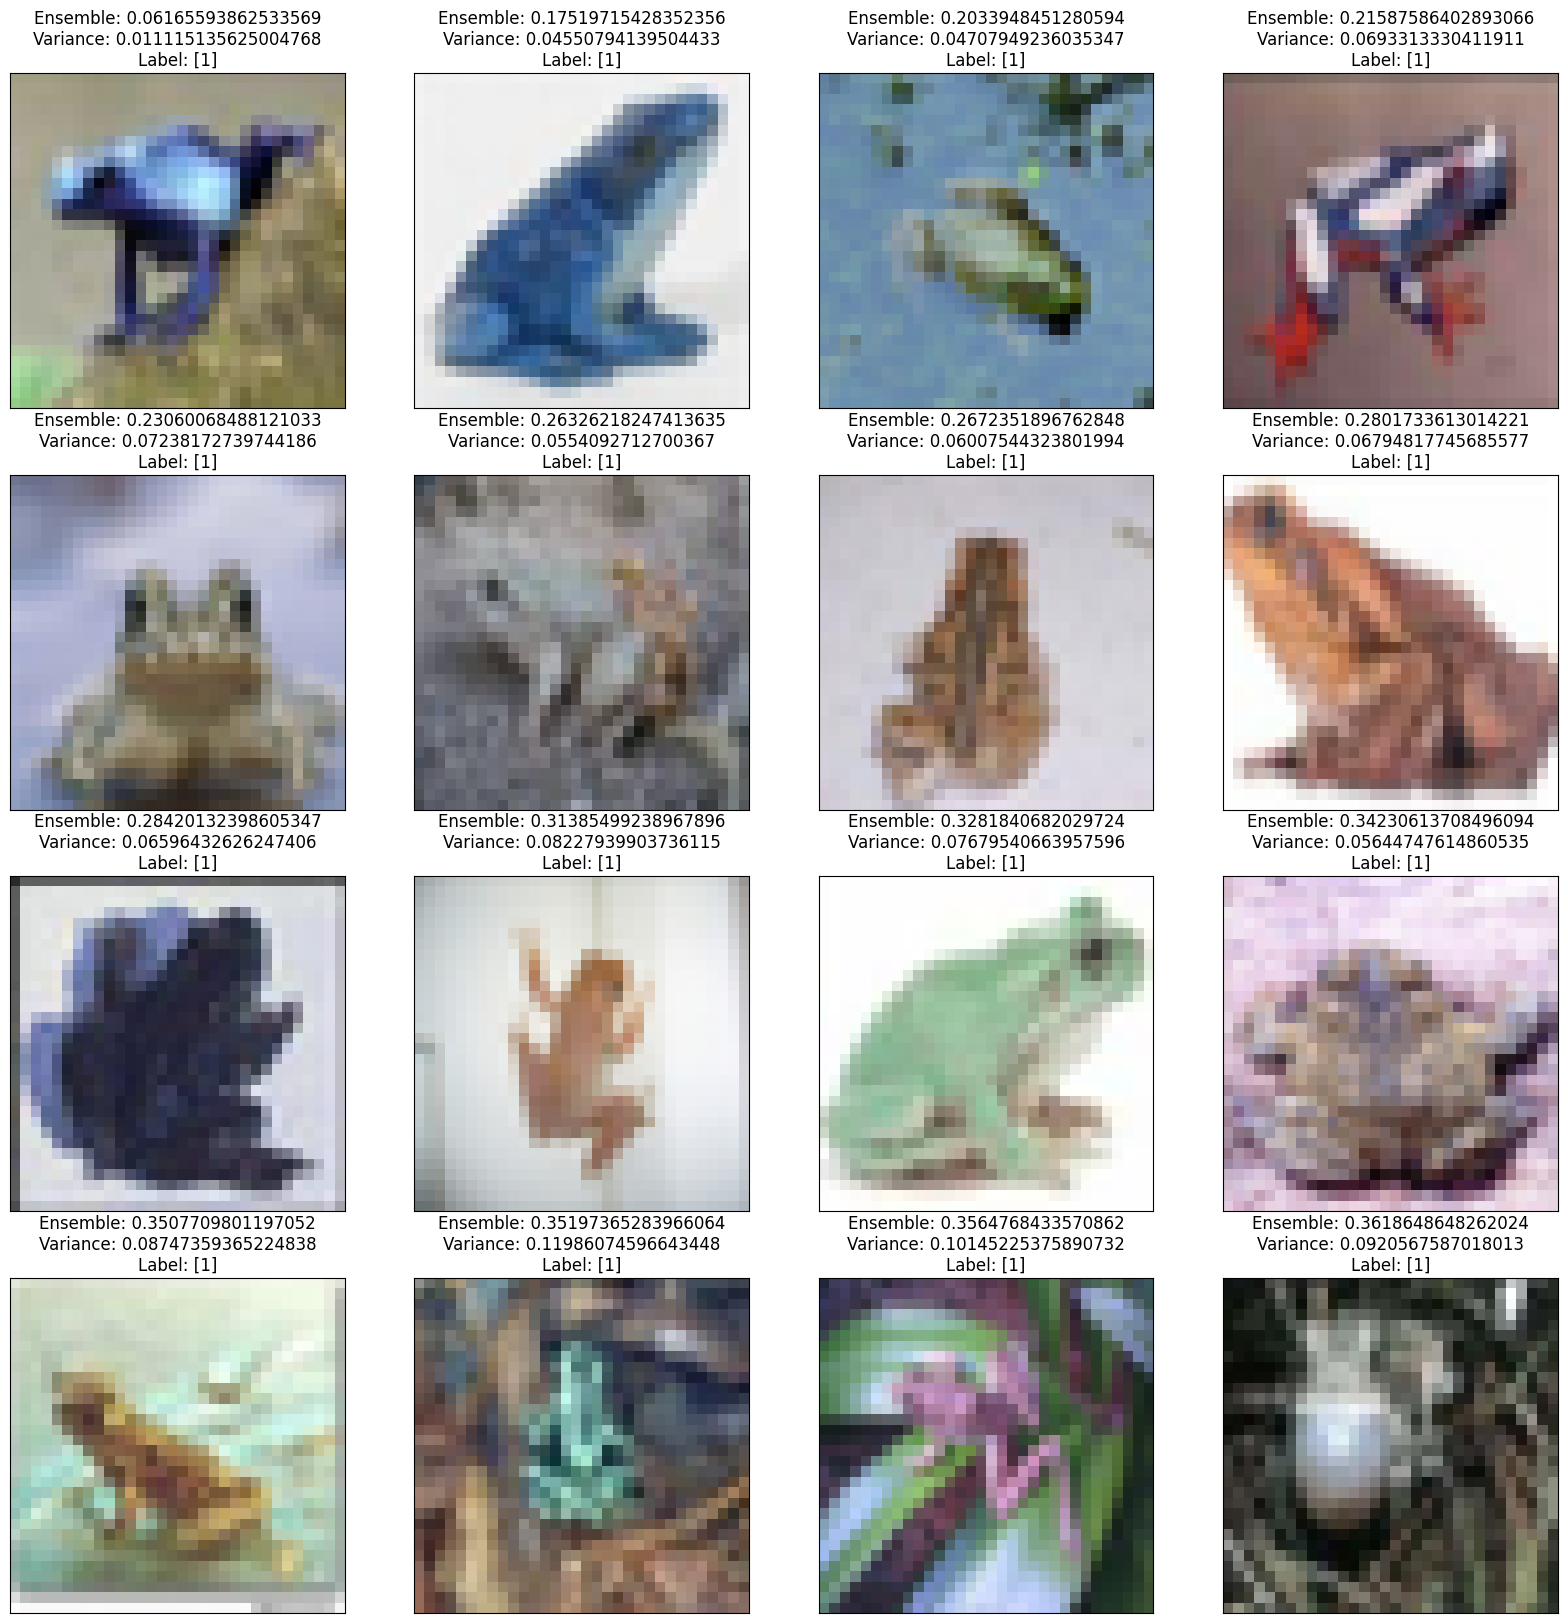

In [376]:



import matplotlib.pyplot as plt

# Create a 10x10 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    # Get the index of the current image
    index = most_confident_outputs[i]

    # Display the image
    ax.imshow(test_images[index], cmap='gray')

    # Get the predictions of the individual models and the ensemble
    # 2 x 10000 x 1
    individual_pred = df['individual_predictions'].iloc[index]
    ensemble_pred = df['mean'].iloc[index]
    ensemble_var = df['variance'].iloc[index]

    # Display the predictions
    ax.set_title(f'Ensemble: {ensemble_pred}\nVariance: {ensemble_var}\nLabel: {test_labels[index]}')

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()


In [394]:

import tensorflow as tf

class NNEnsembleModel(tf.keras.Model):
    def __init__(self, models, **kwargs):
        super(NNEnsembleModel, self).__init__(**kwargs)
        self.models = models
        for model in self.models:
            model.trainable = False


        # Define a small neural network for combining model outputs
        self.combiner = tf.keras.Sequential([
            # tf.keras.layers.Dense(64, activation='relu'),  # First hidden layer
            # tf.keras.layers.Dense(32, activation='relu'),  # Second hidden layer
            tf.keras.layers.Dense(1, activation='sigmoid')                       # Output layer
        ])

    def call(self, inputs):
        # Forward pass through each model and collect their outputs
        outputs = [model(inputs) for model in self.models]
        
        # Concatenate all model outputs
        # concatenated_outputs = tf.concat(outputs, axis=-1)
        
        # Pass the concatenated outputs through the neural network
        # final_output = self.combiner(concatenated_outputs)

        #take mean of the outputs
        final_output = tf.reduce_mean(outputs, axis=0)

        return final_output

class SigmaEnsembleModel(tf.keras.Model):
    def __init__(self, models, **kwargs):
        pass


meta_model = NNEnsembleModel(model_list)
# Fit the the meta model on the validation set and evaluate on the test set
meta_model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])


meta_model_history = meta_model.fit(train_images, train_labels ,  epochs=1, validation_data=(val_images, val_labels), batch_size=config['batchSize'], verbose=1)


/Users/josephcarnec/Documents/CIFAR/.conda/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'nn_ensemble_model_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/josephcarnec/Documents/CIFAR/.conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5004 - auc: 0.8632 - loss: 0.0000e+00

KeyboardInterrupt: 

In [389]:
outputs = meta_model(val_images[:1])
loss = tf.keras.losses.binary_crossentropy(val_labels[:1], outputs)

print(val_labels[:1], outputs[:1])

print(loss)


[[0]] tf.Tensor([[0.00771839]], shape=(1, 1), dtype=float32)
tf.Tensor([0.00774833], shape=(1,), dtype=float32)


In [390]:
meta_model.evaluate(test_images, test_labels)
model_under_test.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8314 - auc: 0.9382 - loss: 0.0000e+00


AttributeError: 'MCDropoutModel' object has no attribute 'evaluate'